In [1]:
%matplotlib inline
import os
import pandas
from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests
import numpy
import math
import itertools 
from scipy.stats import ttest_ind
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats
from sklearn import preprocessing
import seaborn as sns

##### Представление данных

In [2]:
mir_ratio_column = "miR_Ratio"
mir_ratio_2_column = "2_miR Ratio"
hemscore_column = "Hem_Score"
gender_column = "Gender"
diabetes_column = "Diabetes"
age_column = "Age"

##### Обработка данных

In [16]:
class SignificantMicroRNAFinder(object):

    def __init__(
            self, path, mir_ratio_2_theshold=40000, 
            housekeeping_gene="Ct_hsa-miR-16-5p", 
            special_housekeeping_gene=None,
            special_miRNA=None,
            output_files_folder="results/temp",
            output_files_prefix="mir16_hk_",
    ):
        self.path = path
        self.mir_ratio_2_theshold = mir_ratio_2_theshold
        self.housekeeping_gene = housekeeping_gene
        self.special_housekeeping_gene = special_housekeeping_gene
        self.special_miRNA = special_miRNA
        
        self.output_files_folder = output_files_folder
        self.output_files_prefix = output_files_prefix
        if not os.path.exists(self.output_files_folder):
            os.makedirs(self.output_files_folder)
        self.output_prefix = os.path.join(self.output_files_folder, self.output_files_prefix)
        
        self.data = self.prepare_data()
        self.data = self.normalize_expression(self.data)

        
    def normalize_expression(self, df):
        self.norm_exp_cols = []
        exp_cols = [col for col in df.columns if "Ct_" in col]
        for col in exp_cols:
            df[f"{col}_normalized"] = df.apply(
                lambda x: 
                    2**x[col]/2**x[self.housekeeping_gene]
                    # 2**x[self.housekeeping_gene]/2**x[col]
                    if self.special_miRNA is None 
                        or col not in self.special_miRNA
                        or self.special_housekeeping_gene is None 
                        or pandas.isnull(x[self.special_housekeeping_gene])
                    else 
                        2**x[col]/2**x[self.special_housekeeping_gene], 
                        # 2**x[self.special_housekeeping_gene]/2**x[col], 
                axis=1
            )
            self.norm_exp_cols.append(f"{col}_normalized")

        return df

    def prepare_data(self):
        data = pandas.read_excel(self.path)
        data = data.replace(["Undetermined"], [None])
        data[mir_ratio_2_column] = data[mir_ratio_column].map(lambda x: 2**x)

        data.plot.scatter(x=hemscore_column, y=mir_ratio_2_column, title="Before filtering")

        data = self.filter_samples(data)
        data.plot.scatter(x=hemscore_column, y=mir_ratio_2_column, title="After filtering")

        return data


    def filter_samples(self, data):
        return data[data[mir_ratio_2_column] < self.mir_ratio_2_theshold]
    
    @staticmethod
    def highlight_cells(value, threshold=0.1, below=True):
        if below:
            if isinstance(value, float) and abs(value) <= threshold:
                return 'background-color: green'
        else:
            if isinstance(value, float) and abs(value) >= threshold:
                return 'background-color: green'
        
        return 'background-color: white'
    
    def normalize(self,X):
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(X)
        return pandas.DataFrame(x_scaled, columns=X.columns)

    def regression_with_confounding_factors(
        self, group_column="Group",
        confounding_factors=[
            hemscore_column,
            #gender_column,
            diabetes_column,
            age_column,
            mir_ratio_column
        ],
        groups=True
    ):
        le = preprocessing.LabelEncoder()
        
        data = self.data.copy(deep=True)
        
        
        potential_microRNAs = set(self.norm_exp_cols) - set([self.housekeeping_gene + "_normalized"])
        if self.special_housekeeping_gene:
            potential_microRNAs -= set([self.special_housekeeping_gene + "_normalized"])
        
        # correlation between variables
        corr = data[list(potential_microRNAs) + confounding_factors].corr()
        sns.heatmap(corr)
        
        output_suffix = "_%s.xlsx" % "_".join(confounding_factors)

        # Create linear regression object
        lr_scores = pandas.DataFrame()
        regr = linear_model.LinearRegression()
        log2ratio = pandas.DataFrame()
        if groups:
            for group1, group2 in sorted(itertools.combinations(sorted(data[group_column].dropna().unique().tolist()), 2)):
                comparison_name = f"{group1}_vs_{group2}"
                res = {}
                l2r = {}
                for variable in list(potential_microRNAs):
                    # Train the model using the training sets
                    subdf = data[data[group_column].isin([group1, group2])].dropna(subset=confounding_factors + [variable])
                    X = subdf[list(set([variable] + confounding_factors))]

                    y = le.fit(subdf[group_column]).transform(subdf[group_column])

                    X2 = sm.add_constant(X)
                    est = sm.OLS(y, X2)
                    est2 = est.fit()
                    print("\n\n\nComparing groups", group1, group2, "for variable", variable, "\n\n\n")
                    print(est2.summary())
                    res[variable] = est2.pvalues[variable]
                    l2r[variable] = math.log(
                        X.loc[subdf[subdf[group_column] == group1].index][variable].map(lambda x: 1/x).mean() / 
                        X.loc[subdf[subdf[group_column] == group2].index][variable].map(lambda x: 1/x).mean(),
                        2
                    )
                log2ratio = log2ratio.append(pandas.DataFrame(l2r, index=[comparison_name]))
                lr_scores = lr_scores.append(pandas.DataFrame(res, index=[comparison_name]))
                multitests = multipletests(
                    list(lr_scores.T[comparison_name].values), 
                    alpha=0.05, 
                    method="fdr_bh",
                )
                lr_scores.loc[comparison_name + "_mt"] = dict(zip(lr_scores.columns, multitests[1]))
                lr_scores = lr_scores.drop(index=comparison_name)

            lr_scores = lr_scores.sort_index()
            log2ratio = log2ratio.sort_index()

            lr_scores_styler = lr_scores.style.applymap(self.highlight_cells)
            lr_scores_styler.to_excel(f"{self.output_prefix}_group_col_{group_column}_pvalue_significance_{output_suffix}")

            log2ratio_styler = log2ratio.style.applymap(lambda x: self.highlight_cells(x, threshold=2, below=False))
            log2ratio_styler.to_excel(f"{self.output_prefix}_group_col_{group_column}_expression_log2Ratio_{output_suffix}")

            return lr_scores, log2ratio
        else:
            # classic regression
            comparison_name = f"{group_column}"
            res = {}
            l2r = {}
            for variable in list(potential_microRNAs):
                subdf = data.dropna(subset=confounding_factors + [variable])
                X = self.normalize(subdf[list(set([variable] + confounding_factors))])
                y = subdf[group_column].reset_index(drop=True)
                X2 = sm.add_constant(X).reset_index(drop=True)
                est = sm.OLS(y, X2)
                est2 = est.fit()
                print(est2.summary())
                res[variable] = est2.pvalues[variable]
            
            lr_scores = lr_scores.append(pandas.DataFrame(res, index=[comparison_name]))
            multitests = multipletests(
                list(lr_scores.T[comparison_name].values), 
                alpha=0.05, 
                method="fdr_bh",
            )
            lr_scores.loc[comparison_name + "_mt"] = dict(zip(lr_scores.columns, multitests[1]))
            lr_scores = lr_scores.drop(index=comparison_name)
            
            lr_scores_styler = lr_scores.style.applymap(self.highlight_cells)
            lr_scores_styler.to_excel(f"{self.output_prefix}_group_col_{group_column}_pvalue_significance_{output_suffix}")
            
            return lr_scores, None
                
            

##### Поиска значимо изменяющихся микроРНК в miR_CAD_Database




Comparing groups CONTR HT for variable Ct_hsa-miR-146a-5p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     6.718
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           0.000189
Time:                        15:18:25   Log-Likelihood:                -30.168
No. Observations:                  58   AIC:                             70.34
Df Residuals:                      53   BIC:                             80.64
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

strong multicollinearity or other numerical problems.



Comparing groups CONTR MI for variable Ct_hsa-miR-17-5p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     14.98
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           3.28e-09
Time:                        15:18:25   Log-Likelihood:                -17.451
No. Observations:                  60   AIC:                             46.90
Df Residuals:                      54   BIC:                             59.47
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.02

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     35.78
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           4.07e-16
Time:                        15:18:25   Log-Likelihood:               -0.11762
No. Observations:                  61   AIC:                             12.24
Df Residuals:                      55   BIC:                             24.90
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           




Comparing groups CONTR U_CAD for variable Ct_hsa-miR-126-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     13.02
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           2.54e-08
Time:                        15:18:26   Log-Likelihood:                -19.822
No. Observations:                  60   AIC:                             51.64
Df Residuals:                      54   BIC:                             64.21
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------




Comparing groups HT S_CAD for variable Ct_hsa-miR-92a-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     7.167
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           3.47e-05
Time:                        15:18:26   Log-Likelihood:                -27.509
No. Observations:                  59   AIC:                             67.02
Df Residuals:                      53   BIC:                             79.48
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------




Comparing groups HT U_CAD for variable Ct_hsa-miR-155-5p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     3.855
Date:                Sun, 28 Jul 2019   Prob (F-statistic):            0.00479
Time:                        15:18:26   Log-Likelihood:                -32.917
No. Observations:                  58   AIC:                             77.83
Df Residuals:                      52   BIC:                             90.20
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------




Comparing groups MI S_CAD for variable Ct_hsa-miR-337-5p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     3.188
Date:                Sun, 28 Jul 2019   Prob (F-statistic):             0.0143
Time:                        15:18:26   Log-Likelihood:                -32.091
No. Observations:                  55   AIC:                             76.18
Df Residuals:                      49   BIC:                             88.23
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------




Comparing groups MI U_CAD for variable Ct_hsa-miR-126-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     1.816
Date:                Sun, 28 Jul 2019   Prob (F-statistic):              0.125
Time:                        15:18:27   Log-Likelihood:                -38.886
No. Observations:                  60   AIC:                             89.77
Df Residuals:                      54   BIC:                             102.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

(                   Ct_hsa-miR-126-3p_normalized  Ct_hsa-miR-145-5p_normalized  \
 CONTR_vs_HT_mt                         0.858356                      0.858356   
 CONTR_vs_MI_mt                         0.323846                      0.376250   
 CONTR_vs_S_CAD_mt                      0.434237                      0.527806   
 CONTR_vs_U_CAD_mt                      0.714338                      0.004354   
 HT_vs_MI_mt                            0.520547                      0.456745   
 HT_vs_S_CAD_mt                         0.951307                      0.941781   
 HT_vs_U_CAD_mt                         0.340214                      0.123889   
 MI_vs_S_CAD_mt                         0.352093                      0.824975   
 MI_vs_U_CAD_mt                         0.695251                      0.162999   
 S_CAD_vs_U_CAD_mt                      0.571809                      0.571809   
 
                    Ct_hsa-miR-146a-5p_normalized  \
 CONTR_vs_HT_mt                          0.

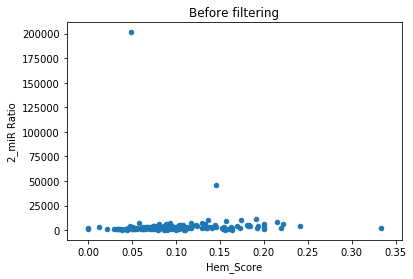

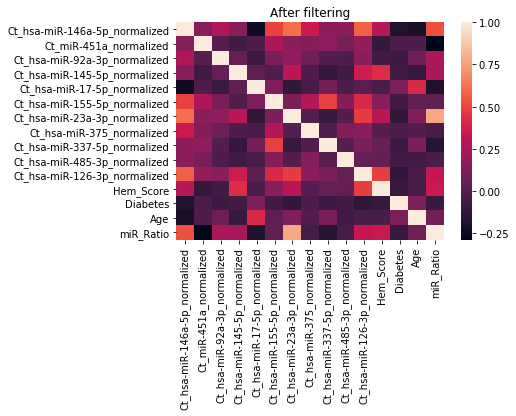

In [17]:
finder = SignificantMicroRNAFinder(
    "data/miR_CAD_Database_2019.xlsx", 
    special_housekeeping_gene="Ct_hsa-miR-16-5p_new",
    special_miRNA = [
        "Ct_hsa-miR-146a-5p",
        "Ct_hsa-miR-375", 
        "Ct_hsa-miR-23a-3p", 
        "Ct_miR-451a"
    ],
    output_files_folder="results/miR_CAD_Database_2019"
)
finder.regression_with_confounding_factors()

##### Поиск значимо изменяющихся микроРНК в AF_Database




Comparing groups AF_CAD AF_HT for variable Ct_hsa-miR-146a-5p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     2.397
Date:                Sun, 28 Jul 2019   Prob (F-statistic):             0.0524
Time:                        15:18:35   Log-Likelihood:                -29.247
No. Observations:                  50   AIC:                             70.49
Df Residuals:                      44   BIC:                             81.97
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     70.87
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           6.35e-20
Time:                        15:18:35   Log-Likelihood:                 19.811
No. Observations:                  50   AIC:                            -27.62
Df Residuals:                      44   BIC:                            -16.15
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               




Comparing groups AF_CAD CONTR_CAD for variable Ct_hsa-miR-19a-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                 -0.027
Method:                 Least Squares   F-statistic:                    0.7937
Date:                Sun, 28 Jul 2019   Prob (F-statistic):              0.562
Time:                        15:18:35   Log-Likelihood:                -26.824
No. Observations:                  40   AIC:                             65.65
Df Residuals:                      34   BIC:                             75.78
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------




Comparing groups AF_CAD HT for variable Ct_hsa-miR-21-5p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     15.28
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           1.50e-08
Time:                        15:18:35   Log-Likelihood:                -9.2885
No. Observations:                  48   AIC:                             30.58
Df Residuals:                      42   BIC:                             41.80
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------




Comparing groups AF_HT CONTR_CAD for variable Ct_hsa-miR-320a_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     2.088
Date:                Sun, 28 Jul 2019   Prob (F-statistic):             0.0849
Time:                        15:18:36   Log-Likelihood:                -29.945
No. Observations:                  50   AIC:                             71.89
Df Residuals:                      44   BIC:                             83.36
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------




Comparing groups AF_HT HT for variable Ct_hsa-miR-328-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     4.065
Date:                Sun, 28 Jul 2019   Prob (F-statistic):            0.00344
Time:                        15:18:36   Log-Likelihood:                -32.494
No. Observations:                  58   AIC:                             76.99
Df Residuals:                      52   BIC:                             89.35
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------




Comparing groups CONTR CONTR_CAD for variable Ct_hsa-miR-23a-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     32.75
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           8.89e-14
Time:                        15:18:36   Log-Likelihood:                 3.5334
No. Observations:                  50   AIC:                             4.933
Df Residuals:                      44   BIC:                             16.41
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------




Comparing groups CONTR HT for variable Ct_hsa-miR-29b-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     7.144
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           0.000112
Time:                        15:18:36   Log-Likelihood:                -29.556
No. Observations:                  58   AIC:                             69.11
Df Residuals:                      53   BIC:                             79.41
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

(                        Ct_hsa-miR-146a-5p_normalized  \
 AF_CAD_vs_AF_HT_mt                           0.733088   
 AF_CAD_vs_CONTR_CAD_mt                       0.997388   
 AF_CAD_vs_CONTR_mt                           0.011733   
 AF_CAD_vs_HT_mt                              0.336580   
 AF_HT_vs_CONTR_CAD_mt                        0.991322   
 AF_HT_vs_CONTR_mt                            0.055374   
 AF_HT_vs_HT_mt                               0.565754   
 CONTR_CAD_vs_HT_mt                           0.790213   
 CONTR_vs_CONTR_CAD_mt                        0.324768   
 CONTR_vs_HT_mt                               0.560057   
 
                         Ct_hsa-miR-150-5p_normalized  \
 AF_CAD_vs_AF_HT_mt                          0.861585   
 AF_CAD_vs_CONTR_CAD_mt                      0.870168   
 AF_CAD_vs_CONTR_mt                          0.252242   
 AF_CAD_vs_HT_mt                             0.039498   
 AF_HT_vs_CONTR_CAD_mt                       0.524860   
 AF_HT_vs_CONTR_mt

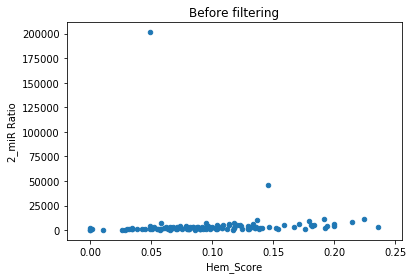

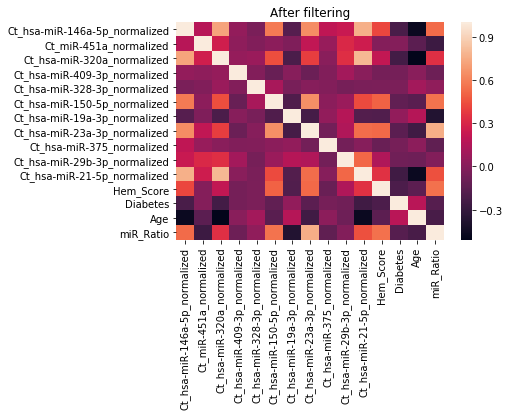

In [18]:
finder_af = SignificantMicroRNAFinder(
    "data/miR_AF_Database_2019.xlsx", 
    output_files_folder="results/miR_AF_Database_2019"
)
finder_af.regression_with_confounding_factors()

##### Поиска значимо изменяющихся микроРНК в зависимости от различных рисковых коэффициентов и шкал

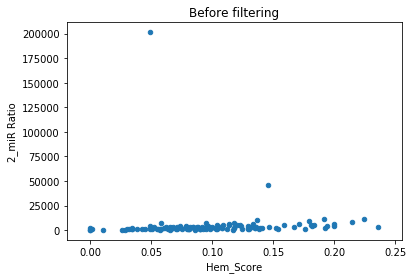

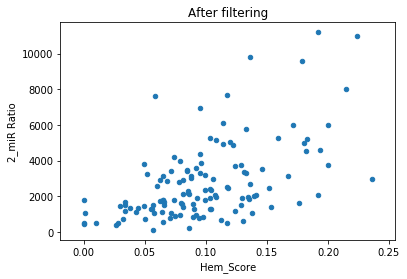

In [19]:
finder = SignificantMicroRNAFinder(
    "data/miR_AF_Database_2019_scales.xlsx", 
    output_files_folder="results/miR_AF_Database_2019_scales"
)




Comparing groups AF_CAD AF_HT for variable Ct_hsa-miR-146a-5p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     2.397
Date:                Sun, 28 Jul 2019   Prob (F-statistic):             0.0524
Time:                        15:18:39   Log-Likelihood:                -29.247
No. Observations:                  50   AIC:                             70.49
Df Residuals:                      44   BIC:                             81.97
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------




Comparing groups AF_CAD CONTR for variable Ct_hsa-miR-409-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     50.73
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           3.65e-17
Time:                        15:18:39   Log-Likelihood:                 12.522
No. Observations:                  50   AIC:                            -13.04
Df Residuals:                      44   BIC:                            -1.572
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------




Comparing groups AF_CAD CONTR_CAD for variable Ct_hsa-miR-23a-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                    0.7686
Date:                Sun, 28 Jul 2019   Prob (F-statistic):              0.579
Time:                        15:18:39   Log-Likelihood:                -26.890
No. Observations:                  40   AIC:                             65.78
Df Residuals:                      34   BIC:                             75.91
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------




Comparing groups AF_CAD HT for variable Ct_hsa-miR-21-5p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     15.28
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           1.50e-08
Time:                        15:18:40   Log-Likelihood:                -9.2885
No. Observations:                  48   AIC:                             30.58
Df Residuals:                      42   BIC:                             41.80
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------




Comparing groups AF_HT CONTR_CAD for variable Ct_hsa-miR-409-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     1.936
Date:                Sun, 28 Jul 2019   Prob (F-statistic):              0.108
Time:                        15:18:40   Log-Likelihood:                -30.298
No. Observations:                  50   AIC:                             72.60
Df Residuals:                      44   BIC:                             84.07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------




Comparing groups AF_HT HT for variable Ct_hsa-miR-19a-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     3.968
Date:                Sun, 28 Jul 2019   Prob (F-statistic):            0.00401
Time:                        15:18:40   Log-Likelihood:                -32.689
No. Observations:                  58   AIC:                             77.38
Df Residuals:                      52   BIC:                             89.74
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------




Comparing groups CONTR HT for variable Ct_hsa-miR-146a-5p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     7.134
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           0.000113
Time:                        15:18:40   Log-Likelihood:                -29.569
No. Observations:                  58   AIC:                             69.14
Df Residuals:                      53   BIC:                             79.44
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------




Comparing groups CONTR_CAD HT for variable Ct_hsa-miR-328-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     10.34
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           1.65e-06
Time:                        15:18:40   Log-Likelihood:                -14.910
No. Observations:                  48   AIC:                             41.82
Df Residuals:                      42   BIC:                             53.05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------




Comparing groups 0 1 for variable Ct_hsa-miR-146a-5p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     21.72
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           1.67e-15
Time:                        15:18:41   Log-Likelihood:                -32.378
No. Observations:                 128   AIC:                             76.76
Df Residuals:                     122   BIC:                             93.87
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------




Comparing groups 0 1 for variable Ct_hsa-miR-146a-5p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     44.94
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           4.19e-26
Time:                        15:18:41   Log-Likelihood:                -22.443
No. Observations:                 128   AIC:                             56.89
Df Residuals:                     122   BIC:                             74.00
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------




Comparing groups 0 1 for variable Ct_hsa-miR-146a-5p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     2.759
Date:                Sun, 28 Jul 2019   Prob (F-statistic):             0.0213
Time:                        15:18:41   Log-Likelihood:                -52.234
No. Observations:                 128   AIC:                             116.5
Df Residuals:                     122   BIC:                             133.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------




Comparing groups 0 1 for variable Ct_hsa-miR-146a-5p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     60.10
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           2.77e-31
Time:                        15:18:42   Log-Likelihood:                -11.823
No. Observations:                 128   AIC:                             35.65
Df Residuals:                     122   BIC:                             52.76
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------




Comparing groups 0 1 for variable Ct_hsa-miR-146a-5p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     60.10
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           2.77e-31
Time:                        15:18:42   Log-Likelihood:                -11.823
No. Observations:                 128   AIC:                             35.65
Df Residuals:                     122   BIC:                             52.76
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

(           Ct_hsa-miR-146a-5p_normalized  Ct_hsa-miR-150-5p_normalized  \
 0_vs_1_mt                       0.231668                      0.868209   
 
            Ct_hsa-miR-19a-3p_normalized  Ct_hsa-miR-21-5p_normalized  \
 0_vs_1_mt                      0.868209                     0.507857   
 
            Ct_hsa-miR-23a-3p_normalized  Ct_hsa-miR-29b-3p_normalized  \
 0_vs_1_mt                      0.612562                      0.514199   
 
            Ct_hsa-miR-320a_normalized  Ct_hsa-miR-328-3p_normalized  \
 0_vs_1_mt                     0.32157                      0.868209   
 
            Ct_hsa-miR-375_normalized  Ct_hsa-miR-409-3p_normalized  \
 0_vs_1_mt                   0.514199                      0.868209   
 
            Ct_miR-451a_normalized  
 0_vs_1_mt                0.514199  ,
         Ct_hsa-miR-146a-5p_normalized  Ct_hsa-miR-150-5p_normalized  \
 0_vs_1                      -1.978596                     -1.836131   
 
         Ct_hsa-miR-19a-3p_normalized  

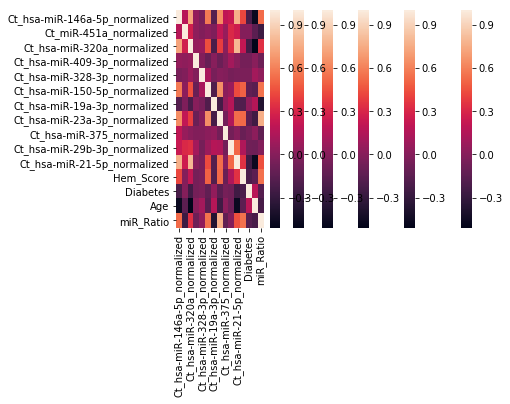

In [20]:
finder.regression_with_confounding_factors()
finder.regression_with_confounding_factors(group_column="CHA2DS2VASc_1")
finder.regression_with_confounding_factors(group_column="CHA2DS2VASc_2")
finder.regression_with_confounding_factors(group_column="SCORE_5")
finder.regression_with_confounding_factors(group_column="ACC_AHA_7,5")
finder.regression_with_confounding_factors(group_column="ACC_AHA_7,5")

                            OLS Regression Results                            
Dep. Variable:                ACC_AHA   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     72.52
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           6.93e-35
Time:                        15:18:42   Log-Likelihood:                -413.25
No. Observations:                 128   AIC:                             838.5
Df Residuals:                     122   BIC:                             855.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

                            OLS Regression Results                            
Dep. Variable:                  SCORE   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1.555
Date:                Sun, 28 Jul 2019   Prob (F-statistic):              0.178
Time:                        15:18:43   Log-Likelihood:                -443.58
No. Observations:                 128   AIC:                             899.2
Df Residuals:                     122   BIC:                             916.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

(          Ct_hsa-miR-146a-5p_normalized  Ct_hsa-miR-150-5p_normalized  \
 SCORE_mt                       0.998115                      0.998115   
 
           Ct_hsa-miR-19a-3p_normalized  Ct_hsa-miR-21-5p_normalized  \
 SCORE_mt                      0.998115                     0.981452   
 
           Ct_hsa-miR-23a-3p_normalized  Ct_hsa-miR-29b-3p_normalized  \
 SCORE_mt                      0.998115                      0.998115   
 
           Ct_hsa-miR-320a_normalized  Ct_hsa-miR-328-3p_normalized  \
 SCORE_mt                    0.981452                      0.998115   
 
           Ct_hsa-miR-375_normalized  Ct_hsa-miR-409-3p_normalized  \
 SCORE_mt                   0.998115                      0.998115   
 
           Ct_miR-451a_normalized  
 SCORE_mt                0.998115  , None)

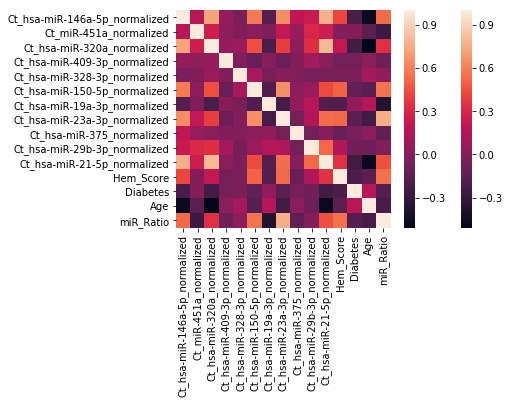

In [21]:
finder.regression_with_confounding_factors(group_column="ACC_AHA", groups=False)
finder.regression_with_confounding_factors(group_column="SCORE", groups=False)